# Assignment 2
Consider the dataset Assignment02_GolfPlayers_Earnings.xlsx.
File location: https://drive.google.com/drive/folders/1Jl8iDu7nGmrqCECbrLqmVafgwE5PYfiU

The file contains game performance and annual earning of 200 top players.

    A) Train a regression tree (CART) using the given data to predict the earning of players.Use a 80/20 split for 
       train/test. 
        1) What is the train and test rmse value?
        2) Which features come out to be important?
    B) Train a multiple regression model and compare the test rmse value? Use the exact same split as in case A
       1) Does the data exhibit multicollinearity?
    C) Train a cubist model using the cubist package. What is the test rmse value? Use the exact same split as in case A

Which model give the best performance on test data? Why do you think that is the case?

# Answers
A) Train a regression tree (CART) using the given data to predict the earning of players.Use a 80/20 split for 
   train/test. 
    
    1) What is the train and test rmse value?
        - Train RMSE is 388161.31
        - Test  RMSE is 509173.13
    2) Which features come out to be important?
       Features importance as in below table:
       
|feature_name	 | importance |
|--------------- |------------|
|Top 10s	     | 0.840471   |
|Wins	         | 0.152820   |
|Cuts Made	     | 0.006710   |

B) Train a multiple regression model and compare the test rmse value? Use the exact same split as in case A.
    
    - Train RMSE is 330577.56
    - Test  RMSE is 353834.29
   
    1) Does the data exhibit multicollinearity?
       Data has strong multicollinearity. To avoid this, in this solution, following variables have been removed:
      'Rounds', 'Putting Average', 'Pars', 'Greens in Regulation', 'Birdies', 'Bogies', 'Yards/Drive',
      'Driving Accuracy', 'Events', 'Sand Save Pct', 'Age', 'Eagles'
C) Train a cubist model using the cubist package. What is the test rmse value? Use the exact same split as in case A

    - Train RMSE is 281885.81
    - Test  RMSE is 317660.4
    - Tried tuning cubist parameters, but that did not result in performance gain.
    
**Which model give the best performance on test data? Why do you think that is the case?**

We can compare the three techniques using below table:

|Modelling method	      | Train RMSE | Test RMSE  |
|-------------------------|------------|------------|
|Decision Tree regression | 388161.31  | 509173.13  |
|Linear Regression	      | 330577.56  | 353834.29  |
|Cubist	                  | 281885.81  | 317660.4   |

Decison tree performs worst and cubist performs best, both in terms of training and test rmse. After plotting the variables, we see that relationship of `Earnings` with `Top 10s`, is linear. With other two variables i.e. `Wins` and `Cuts Made`, its not linear. Since Cubist can handle non-linearity while creating rules to segment data, and on segmented data, it uses regression. Hence its performing best. Linear regression is able to use the linearlity in data and able to perform better than Decision tree. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from cubist import Cubist

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("Assignment02_GolfPlayer_Earnings.xlsx")
#df.head(2)

In [3]:
counts_na = df.isna().sum()
counts_na[counts_na > 0]

Age                     12
Yards/Drive              3
Driving Accuracy         3
Greens in Regulation     3
Putting Average         31
Sand Save Pct            3
Eagles                   5
Birdies                  5
Pars                     5
Bogies                   5
dtype: int64

In [4]:
df_1 = df.dropna()
print(df.shape)
print(df_1.shape)

(200, 18)
(157, 18)


In [5]:
x_vars = ['Age', 'Events', 'Rounds', 'Cuts Made', 'Top 10s',
          'Wins', 'Yards/Drive', 'Driving Accuracy',
          'Greens in Regulation', 'Putting Average', 'Sand Save Pct', 'Eagles',
          'Birdies', 'Pars', 'Bogies'
         ]
y_var = 'Earnings'
df_x = df[x_vars]
y = df[y_var]

In [6]:
imputer = KNNImputer(n_neighbors=5)
df_x = pd.DataFrame(imputer.fit_transform(df_x), columns = x_vars)
counts_na = df_x.isna().sum()
counts_na[counts_na > 0] #check if we have na values in data set

Series([], dtype: int64)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size=0.2, random_state=1)

In [8]:
tune_parm_space = {'min_samples_split':range(1, 20),
                   'max_depth':range(1, 20),
                   'min_samples_leaf':range(1, 20)
                  }
tree_model = GridSearchCV(DecisionTreeRegressor(random_state= 1), tune_parm_space, cv=5)
tree_model.fit(x_train, y_train);

In [9]:
print(np.round(tree_model.best_score_, 2))
print(tree_model.best_params_)

0.79
{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 11}


In [10]:
train_rmse = mean_squared_error(y_train, tree_model.predict(x_train), squared=False)
test_rmse = mean_squared_error(y_test, tree_model.predict(x_test), squared=False)
print(f"Train RMSE is {np.round(train_rmse, 2)}")
print(f"Test  RMSE is {np.round(test_rmse, 2)}")

Train RMSE is 388161.31
Test  RMSE is 509173.13


In [11]:
feature_importance = tree_model.best_estimator_.feature_importances_
df_feature_imprt = pd.DataFrame({'feature_name' : x_vars, 'importance':feature_importance})
df_feature_imprt.sort_values(by='importance', ascending=False)[df_feature_imprt['importance'] > 0]

,feature_name,importance
4,Top 10s,0.840471
5,Wins,0.152820
3,Cuts Made,0.006710


# B
Train a multiple regression model and compare the test rmse value? Use the exact same split as in case A
    
    - 1) Does the data exhibit multicollinearity?

In [12]:
# # Check for multicollinearity
# Remove Rounds, since it has highest vif value of 10,384.35
# Remove Putting Average, since it has highest vif value of 6916.65
# Remove Pars, since it has highest vif value of 825.76
# Remove Greens in Regulation, since it has highest vif value of 458.73
# Remove Birdies, since it has highest vif value of 277.17
# Remove Bogies, since it has highest vif value of 260.59
# Remove Yards/Drive, since it has highest vif value of 124.06
# Remove Driving Accuracy, since it has highest vif value of 74.35
# Remove Events, since it has highest vif value of 33.73
# Remove Sand Save Pct, since it has highest vif value of 33.73
# Remove Age, instead of Cuts Made(since its coming important in decision tree), since it has highest vif value of 6.680
# Remove Eagles, instead of Cuts Made(since its coming important in decision tree), since it has highest vif value of 5.00
drop_vars = ['Rounds', 'Putting Average', 'Pars', 'Greens in Regulation', 'Birdies', 'Bogies', 'Yards/Drive',
             'Driving Accuracy', 'Events', 'Sand Save Pct', 'Age', 'Eagles'
            ]
x_var = x_vars 
x_var = [x for x in x_var if x not in drop_vars] # Drop variables present in drop_vars
X = x_train[x_var]
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
vif.sort_values(ascending=False)[0:5]

Top 10s      3.745986
Cuts Made    2.983453
Wins         1.621861
dtype: float64

In [13]:
def fit_lin_reg_with_intercept(X, Y):
    X = sm.add_constant(X) # adding a constan
    reg_model = sm.OLS(Y,X).fit()
    return reg_model

In [14]:
reg_model = fit_lin_reg_with_intercept(X=x_train[x_var], Y=y_train)
#print(reg_model.summary()) # model r-sq is 0.921 and all variables significant

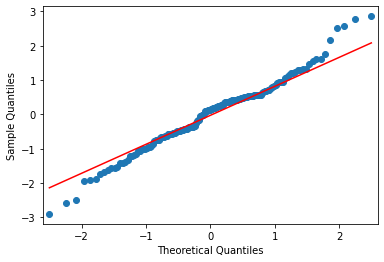

In [15]:
residuals = reg_model.resid 
sm.qqplot(residuals, fit=True, line="q")
plt.show() # at high values, model seem to be predicting high and at lower values, model seems to be predicting lower

In [16]:
train_rmse = mean_squared_error(y_train, reg_model.predict(sm.add_constant(x_train[x_var])), squared=False)
test_rmse = mean_squared_error(y_test, reg_model.predict(sm.add_constant(x_test[x_var])), squared=False)
print(f"Train RMSE is {np.round(train_rmse, 2)}")
print(f"Test  RMSE is {np.round(test_rmse, 2)}")

Train RMSE is 330577.56
Test  RMSE is 353834.29


# C. 

In [17]:
# Cubist Model Tree
cubist_model = Cubist(random_state=0) # <- model parameters here
cubist_model.fit(x_train, y_train);

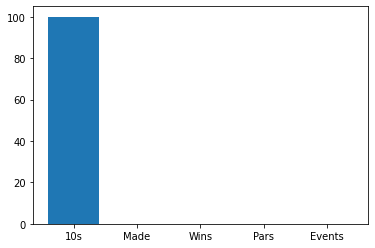

In [18]:
# Plot feature importance
plt.figure(figsize=(6, 4))
importance = cubist_model.feature_importances_
index = ~ importance['Conditions'].isnull().iloc[:, 0]
importance_non_null = importance[index].iloc[:, 0:3]
importance_non_null
plt.bar(importance_non_null.Variable, importance_non_null.Conditions);

In [19]:
train_rmse = mean_squared_error(y_train, cubist_model.predict(x_train), squared=False)
test_rmse = mean_squared_error(y_test, cubist_model.predict(x_test), squared=False)
print(f"Train RMSE is {np.round(train_rmse, 2)}")
print(f"Test  RMSE is {np.round(test_rmse, 2)}")

Train RMSE is 281885.81
Test  RMSE is 317660.4


In [20]:
#Cubist().get_params()
#DecisionTreeRegressor().get_params()

In [21]:
tune_parm_space = [{'n_committees':[1, 2, 3, 4, 5]},
                   
                   {'n_committees':[1, 2, 3, 4, 5],
                    'neighbors':   [1, 2, 3, 4, 5],
                   'composite':    [True]
                   }
                  ]
cubist_model = GridSearchCV(Cubist(random_state=0), tune_parm_space, cv=5)
cubist_model.fit(x_train, y_train);

In [22]:
cubist_model.best_params_

{'n_committees': 4}

In [23]:
train_rmse = mean_squared_error(y_train, cubist_model.predict(x_train), squared=False)
test_rmse = mean_squared_error(y_test, cubist_model.predict(x_test), squared=False)
print(f"Train RMSE is {np.round(train_rmse, 2)}")
print(f"Test  RMSE is {np.round(test_rmse, 2)}")

Train RMSE is 282687.02
Test  RMSE is 319384.75


In [24]:
len(y_var)


8

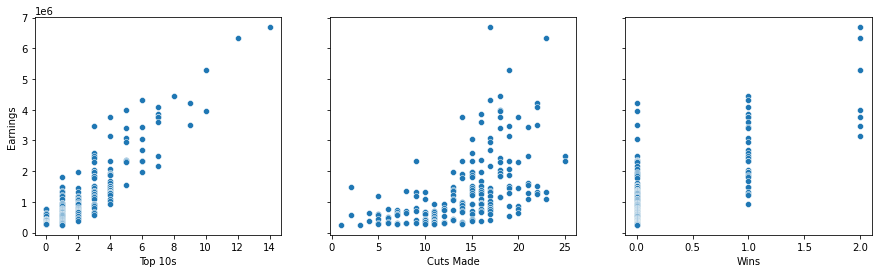

In [25]:
#initialize figure
vrb_plot = ['Top 10s', 'Cuts Made', 'Wins']
fig, axes = plt.subplots(len([y_var]), len(vrb_plot), figsize=(15, 4), sharex=False, sharey=True)
# Plot digits on each subplot
for i, ax in enumerate(axes.ravel()):
    x_var = vrb_plot[i]
    sns.scatterplot(ax=ax, x=df_x[x_var], y=y)

#plt.xticks([]) # to remove x tick marks
#plt.yticks([]) # to remove y tick marks
plt.show()